<h1>CIFAR 10</h1>

<h1>Importing Modules</h1>


In [1]:
import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt

print(torch.__version__)

1.10.0+cu102


# Loading Data

In [2]:
train_batchsize = 100
test_batchsize = 10
resized_img_size = 32
transform = torchvision.transforms.Compose(
    [torchvision.transforms.Resize(size=(resized_img_size, resized_img_size)),
     torchvision.transforms.ToTensor()])
train_data = torchvision.datasets.CIFAR10(root='data', train=True,
                                        download=True, transform=transform)
test_data = torchvision.datasets.CIFAR10(root='data', train=False,
                                       download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(train_data, batch_size=train_batchsize)

test_loader = torch.utils.data.DataLoader(test_data, batch_size=test_batchsize)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


# Visualize data

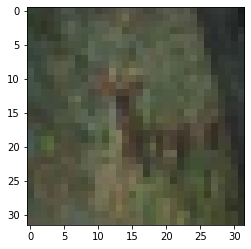

In [3]:
plt.imshow(train_data[10][0].permute(1,2,0)) 

# Model

In [4]:
import torch.nn as nn
import torch.nn.functional as F 
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3,5,(5,5),padding = "same")
        self.pool1 = nn.MaxPool2d((3,3),stride=2)
        self.conv2 = nn.Conv2d(5,7,(5,5),padding="same")
        self.pool2 = nn.MaxPool2d((3,3),stride=2)
        self.conv3 = nn.Conv2d(7,9,(5,5),padding="same")
        self.pool3 = nn.MaxPool2d((3,3),stride=2)
        self.linearlayer = nn.Linear(144,256)
        self.linearlayer2 = nn.Linear(256,10)
    def forward(self,X):
        X = self.pool1(F.relu(self.conv1(X)))
        X = self.pool2(F.relu(self.conv2(X)))
        X = self.pool3(F.relu(self.conv3(X)))
        X = X.view(-1,81) #Flatten
        #X = F.relu(self.linearlayer(X))
        #X = self.linearlayer2(X)
        return X
model = Net()
#print(train_loader)
#print(model([train_data[0][0]]))

In [24]:
from ADAM import ADAM
trainingLoss = {}
# Fixed seed for random weight initialization (to keep the weights same for all
# the models)
#torch.manual_seed(3)
seed = 17

file = open("./results/TrainingLossess.txt","w")
def trainDifOptimizer(optmzr):
    torch.manual_seed(seed)
    model = Net()
    criterion = nn.CrossEntropyLoss()
    optimizer = None
    if optmzr=='Adam_scratch':
      optimizer = ADAM(model.parameters(), lr=0.01) # lr=0.001 -> standard
    else:
      optimizer = getattr(torch.optim, optmzr)(model.parameters(), lr=0.01)
    
    n_epochs = 80  # suggest training between 20-50 epochs

    model.train()  # prep model for training
    trainLossForOptimizer = []
    print("Optimizer : ", optmzr, "\n")
    file.writelines(["Optimizer : ", optmzr, "\n"])
    for epoch in range(n_epochs):
        train_loss = 0.0

        for data, target in train_loader:
            # clear the gradients of all optimized variables
            optimizer.zero_grad()
            # forward pass: compute predicted outputs by passing inputs to the model
            output = model(data)
            # calculate the loss
            loss = criterion(output, target)
            # backward pass: compute gradient of the loss with respect to model parameters
            loss.backward()
            # perform a single optimization step (parameter update)
            optimizer.step()
            # update running training loss
            train_loss += loss.item()*data.size(0)

        # print training statistics
        # calculate average loss over an epoch
        train_loss = train_loss/len(train_loader.dataset)
        trainLossForOptimizer.append(train_loss)
        
        print('Epoch: {} \tTraining Loss: {:.6f}'.format(
            epoch+1,
            train_loss
        ))
        file.write('Epoch: {} \tTraining Loss: {:.6f}'.format(
            epoch+1,
            train_loss
        ))
    torch.save(model, 'saved_models/'+optmzr+'_cnn_model')
    trainingLoss[optmzr] = trainLossForOptimizer
    print("\n-----------------------------------------\n")
    file.write("\n-----------------------------------------\n")

optimizersLst = ['Adam', 'RMSprop','SGD','Adadelta','Adam_scratch']

for optmzr in optimizersLst:
    trainDifOptimizer(optmzr)
file.write("***********************************OVER********************************")
print(trainingLoss)

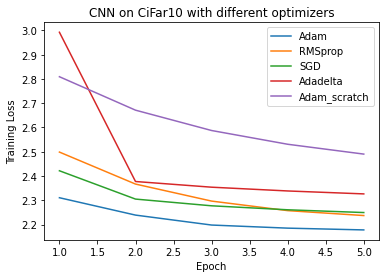

In [11]:
Xval = np.arange(1, 6,1)

plt.xlabel("Epoch")  # add X-axis label
plt.ylabel("Training Loss")  # add Y-axis label
plt.title("CNN on CiFar10 with different optimizers")  # add title
for key, value in trainingLoss.items():
    plt.plot(Xval, value, label=key)

plt.legend()
plt.show()

In [12]:
optimizersLst = ['Adam_scratch', 'Adam', 'RMSprop','SGD','Adadelta']

for optmzr in optimizersLst:
    trainDifOptimizer(optmzr)
file.write("***********************************OVER********************************")
print(trainingLoss)

Optimizer :  Adam_scratch 

Epoch: 1 	Training Loss: 2.809185
Epoch: 2 	Training Loss: 2.671320
Epoch: 3 	Training Loss: 2.587451
Epoch: 4 	Training Loss: 2.530806
Epoch: 5 	Training Loss: 2.490246

-----------------------------------------

Optimizer :  Adam 

Epoch: 1 	Training Loss: 2.310399
Epoch: 2 	Training Loss: 2.238809
Epoch: 3 	Training Loss: 2.197813
Epoch: 4 	Training Loss: 2.185024
Epoch: 5 	Training Loss: 2.177727

-----------------------------------------

Optimizer :  RMSprop 

Epoch: 1 	Training Loss: 2.498582
Epoch: 2 	Training Loss: 2.366708
Epoch: 3 	Training Loss: 2.296552
Epoch: 4 	Training Loss: 2.257221
Epoch: 5 	Training Loss: 2.236961

-----------------------------------------

Optimizer :  SGD 

Epoch: 1 	Training Loss: 2.421538
Epoch: 2 	Training Loss: 2.304808
Epoch: 3 	Training Loss: 2.277127
Epoch: 4 	Training Loss: 2.260698
Epoch: 5 	Training Loss: 2.249340

-----------------------------------------

Optimizer :  Adadelta 

Epoch: 1 	Training Loss: 2.992

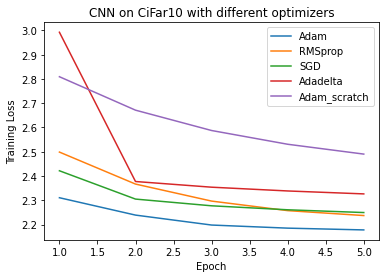

In [13]:
Xval = np.arange(1, 6,1)

plt.xlabel("Epoch")  # add X-axis label
plt.ylabel("Training Loss")  # add Y-axis label
plt.title("CNN on CiFar10 with different optimizers")  # add title
for key, value in trainingLoss.items():
    plt.plot(Xval, value, label=key)

plt.legend()
plt.show()

In [15]:
# 35 epochs
optimizersLst = ['Adam_scratch', 'Adam', 'RMSprop','SGD','Adadelta']

for optmzr in optimizersLst:
    trainDifOptimizer(optmzr)
file.write("***********************************OVER********************************")
print(trainingLoss)

Optimizer :  Adam_scratch 

Epoch: 1 	Training Loss: 2.809185
Epoch: 2 	Training Loss: 2.671320
Epoch: 3 	Training Loss: 2.587451
Epoch: 4 	Training Loss: 2.530806
Epoch: 5 	Training Loss: 2.490246
Epoch: 6 	Training Loss: 2.468014
Epoch: 7 	Training Loss: 2.452010
Epoch: 8 	Training Loss: 2.439709
Epoch: 9 	Training Loss: 2.429913
Epoch: 10 	Training Loss: 2.420230
Epoch: 11 	Training Loss: 2.412589
Epoch: 12 	Training Loss: 2.405695
Epoch: 13 	Training Loss: 2.400397
Epoch: 14 	Training Loss: 2.394833
Epoch: 15 	Training Loss: 2.390467
Epoch: 16 	Training Loss: 2.386072
Epoch: 17 	Training Loss: 2.382052
Epoch: 18 	Training Loss: 2.378398
Epoch: 19 	Training Loss: 2.374604
Epoch: 20 	Training Loss: 2.370660
Epoch: 21 	Training Loss: 2.367050
Epoch: 22 	Training Loss: 2.363562
Epoch: 23 	Training Loss: 2.359935
Epoch: 24 	Training Loss: 2.356252
Epoch: 25 	Training Loss: 2.353204
Epoch: 26 	Training Loss: 2.350767
Epoch: 27 	Training Loss: 2.348327
Epoch: 28 	Training Loss: 2.346101
E

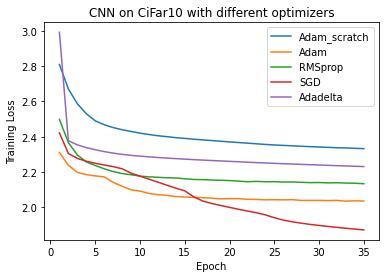

In [17]:
Xval = np.arange(1, 36,1)

plt.xlabel("Epoch")  # add X-axis label
plt.ylabel("Training Loss")  # add Y-axis label
plt.title("CNN on CiFar10 with different optimizers")  # add title
for key, value in trainingLoss.items():
    plt.plot(Xval, value, label=key)

plt.legend()
plt.show()

In [19]:
#model = Net(*args, **kwargs)
optmzr = 'Adam'
#model.load_state_dict(torch.load('saved_models/'+optmzr+'_cnn_model'))

model = torch.load('saved_models/'+optmzr+'_cnn_model')
model.eval()

model.eval()

Net(
  (conv1): Conv2d(3, 5, kernel_size=(5, 5), stride=(1, 1), padding=same)
  (pool1): MaxPool2d(kernel_size=(3, 3), stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(5, 7, kernel_size=(5, 5), stride=(1, 1), padding=same)
  (pool2): MaxPool2d(kernel_size=(3, 3), stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(7, 9, kernel_size=(5, 5), stride=(1, 1), padding=same)
  (pool3): MaxPool2d(kernel_size=(3, 3), stride=2, padding=0, dilation=1, ceil_mode=False)
  (linearlayer): Linear(in_features=144, out_features=256, bias=True)
  (linearlayer2): Linear(in_features=256, out_features=10, bias=True)
)

In [21]:
# 50 epochs
optimizersLst = ['Adam_scratch', 'Adam', 'RMSprop','SGD','Adadelta']

for optmzr in optimizersLst:
    trainDifOptimizer(optmzr)
file.write("***********************************OVER********************************")
print(trainingLoss)

Optimizer :  Adam_scratch 

Epoch: 1 	Training Loss: 2.401655
Epoch: 2 	Training Loss: 2.254491
Epoch: 3 	Training Loss: 2.197518
Epoch: 4 	Training Loss: 2.158920
Epoch: 5 	Training Loss: 2.137841
Epoch: 6 	Training Loss: 2.125303
Epoch: 7 	Training Loss: 2.116441
Epoch: 8 	Training Loss: 2.108799
Epoch: 9 	Training Loss: 2.101002
Epoch: 10 	Training Loss: 2.093902
Epoch: 11 	Training Loss: 2.086959
Epoch: 12 	Training Loss: 2.080963
Epoch: 13 	Training Loss: 2.075574
Epoch: 14 	Training Loss: 2.070760
Epoch: 15 	Training Loss: 2.065129
Epoch: 16 	Training Loss: 2.060572
Epoch: 17 	Training Loss: 2.055479
Epoch: 18 	Training Loss: 2.051123
Epoch: 19 	Training Loss: 2.047125
Epoch: 20 	Training Loss: 2.043104
Epoch: 21 	Training Loss: 2.039800
Epoch: 22 	Training Loss: 2.028367
Epoch: 23 	Training Loss: 2.002502
Epoch: 24 	Training Loss: 1.990476
Epoch: 25 	Training Loss: 1.981525
Epoch: 26 	Training Loss: 1.974785
Epoch: 27 	Training Loss: 1.969057
Epoch: 28 	Training Loss: 1.964177
E

Epoch: 29 	Training Loss: 2.324665
Epoch: 30 	Training Loss: 2.323132
Epoch: 31 	Training Loss: 2.321665
Epoch: 32 	Training Loss: 2.320247
Epoch: 33 	Training Loss: 2.318870
Epoch: 34 	Training Loss: 2.317536
Epoch: 35 	Training Loss: 2.316233
Epoch: 36 	Training Loss: 2.314962
Epoch: 37 	Training Loss: 2.313732
Epoch: 38 	Training Loss: 2.312526
Epoch: 39 	Training Loss: 2.311346
Epoch: 40 	Training Loss: 2.310190
Epoch: 41 	Training Loss: 2.309061
Epoch: 42 	Training Loss: 2.307960
Epoch: 43 	Training Loss: 2.306904
Epoch: 44 	Training Loss: 2.305884
Epoch: 45 	Training Loss: 2.304877
Epoch: 46 	Training Loss: 2.303893
Epoch: 47 	Training Loss: 2.302922
Epoch: 48 	Training Loss: 2.301970
Epoch: 49 	Training Loss: 2.301031
Epoch: 50 	Training Loss: 2.300103

-----------------------------------------

{'Adam_scratch': [2.401654939174652, 2.2544905195236207, 2.197517520427704, 2.158919840097427, 2.1378410325050354, 2.125303226232529, 2.116441390275955, 2.108798589468002, 2.101001971960

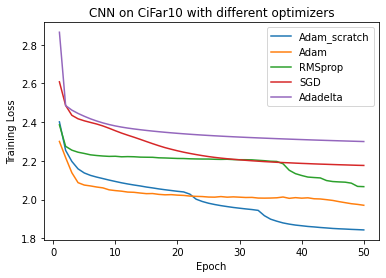

In [22]:
Xval = np.arange(1, 51,1)

plt.xlabel("Epoch")  # add X-axis label
plt.ylabel("Training Loss")  # add Y-axis label
plt.title("CNN on CiFar10 with different optimizers")  # add title
for key, value in trainingLoss.items():
    plt.plot(Xval, value, label=key)

plt.legend()
plt.show()

In [25]:
# 80 epochs
optimizersLst = ['Adam_scratch', 'Adam', 'RMSprop','SGD','Adadelta']

for optmzr in optimizersLst:
    trainDifOptimizer(optmzr)
file.write("***********************************OVER********************************")
print(trainingLoss)

Optimizer :  Adam_scratch 

Epoch: 1 	Training Loss: 2.428508
Epoch: 2 	Training Loss: 2.298510
Epoch: 3 	Training Loss: 2.252151
Epoch: 4 	Training Loss: 2.222760
Epoch: 5 	Training Loss: 2.167505
Epoch: 6 	Training Loss: 2.112430
Epoch: 7 	Training Loss: 2.060227
Epoch: 8 	Training Loss: 1.988547
Epoch: 9 	Training Loss: 1.962808
Epoch: 10 	Training Loss: 1.944676
Epoch: 11 	Training Loss: 1.929772
Epoch: 12 	Training Loss: 1.916470
Epoch: 13 	Training Loss: 1.904632
Epoch: 14 	Training Loss: 1.894696
Epoch: 15 	Training Loss: 1.885857
Epoch: 16 	Training Loss: 1.878112
Epoch: 17 	Training Loss: 1.871069
Epoch: 18 	Training Loss: 1.865148
Epoch: 19 	Training Loss: 1.859689
Epoch: 20 	Training Loss: 1.854990
Epoch: 21 	Training Loss: 1.850402
Epoch: 22 	Training Loss: 1.845839
Epoch: 23 	Training Loss: 1.841367
Epoch: 24 	Training Loss: 1.837835
Epoch: 25 	Training Loss: 1.834344
Epoch: 26 	Training Loss: 1.830895
Epoch: 27 	Training Loss: 1.827699
Epoch: 28 	Training Loss: 1.824534
E

Epoch: 72 	Training Loss: 1.828033
Epoch: 73 	Training Loss: 1.829948
Epoch: 74 	Training Loss: 1.831297
Epoch: 75 	Training Loss: 1.830737
Epoch: 76 	Training Loss: 1.831165
Epoch: 77 	Training Loss: 1.827678
Epoch: 78 	Training Loss: 1.829836
Epoch: 79 	Training Loss: 1.827165
Epoch: 80 	Training Loss: 1.826516

-----------------------------------------

Optimizer :  SGD 

Epoch: 1 	Training Loss: 2.794490
Epoch: 2 	Training Loss: 2.728806
Epoch: 3 	Training Loss: 2.719724
Epoch: 4 	Training Loss: 2.711757
Epoch: 5 	Training Loss: 2.701782
Epoch: 6 	Training Loss: 2.438997
Epoch: 7 	Training Loss: 2.227027
Epoch: 8 	Training Loss: 2.203055
Epoch: 9 	Training Loss: 2.180610
Epoch: 10 	Training Loss: 2.159520
Epoch: 11 	Training Loss: 2.142042
Epoch: 12 	Training Loss: 2.126692
Epoch: 13 	Training Loss: 2.113428
Epoch: 14 	Training Loss: 2.102218
Epoch: 15 	Training Loss: 2.092766
Epoch: 16 	Training Loss: 2.084367
Epoch: 17 	Training Loss: 2.077059
Epoch: 18 	Training Loss: 2.070389
E

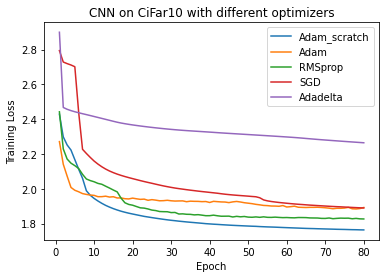

In [26]:
Xval = np.arange(1, 81,1)

plt.xlabel("Epoch")  # add X-axis label
plt.ylabel("Training Loss")  # add Y-axis label
plt.title("CNN on CiFar10 with different optimizers")  # add title
for key, value in trainingLoss.items():
    plt.plot(Xval, value, label=key)

plt.legend()
plt.show()